In [1]:
from sklearn.model_selection import train_test_split
from torch.utils.data.dataloader import DataLoader
import tiktoken

from src.data_loader import load_data
from src.utils import load_config
from src import wikipedia_article_dataset
from src.models import CNN, CNNModel
from src.evaluation import evaluate_model

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


In [2]:
MAX_LENGTH = 400
BATCH_SIZE = 16

EMBEDDING_DIM = 128
NUM_FILTERS = 10
FILTER_SIZES = [3, 4, 5]
NUM_CLASSES = 2
DROPOUT = 0.5

In [3]:
config = load_config("just-load")

In [4]:
df = load_data(config["data_loader"], "binary")

In [5]:
df = df.head(500)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(list(df["text"]), list(df["label"]), test_size=0.2)

In [7]:
tokenizer = tiktoken.get_encoding("cl100k_base")

In [8]:
model = CNNModel(
    EMBEDDING_DIM,
    NUM_FILTERS,
    FILTER_SIZES,
    NUM_CLASSES,
    MAX_LENGTH,
    DROPOUT
)

In [9]:
model.fit(X_train, y_train, 0.001, 10, BATCH_SIZE)

Epoch: 0, loss: 0.7067039752006531
Epoch: 1, loss: 0.6667285108566284
Epoch: 2, loss: 0.6589697909355163
Epoch: 3, loss: 0.6468897581100463
Epoch: 4, loss: 0.6381572890281677
Epoch: 5, loss: 0.6104387402534485
Epoch: 6, loss: 0.5972739279270172
Epoch: 7, loss: 0.5702569818496704
Epoch: 8, loss: 0.5573936522006988
Epoch: 9, loss: 0.5485137140750885


In [10]:
predictions = model.predict(X_test)

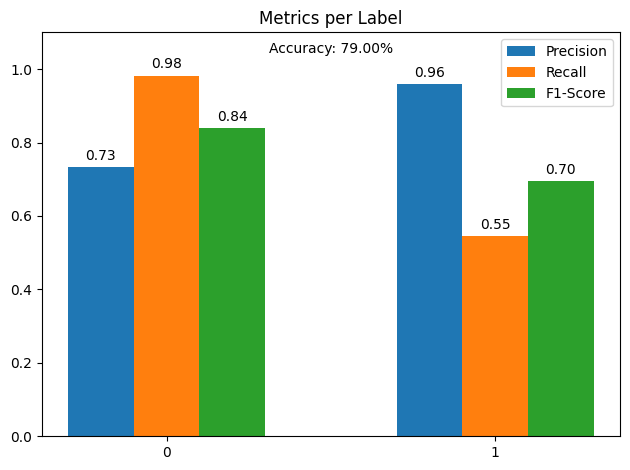

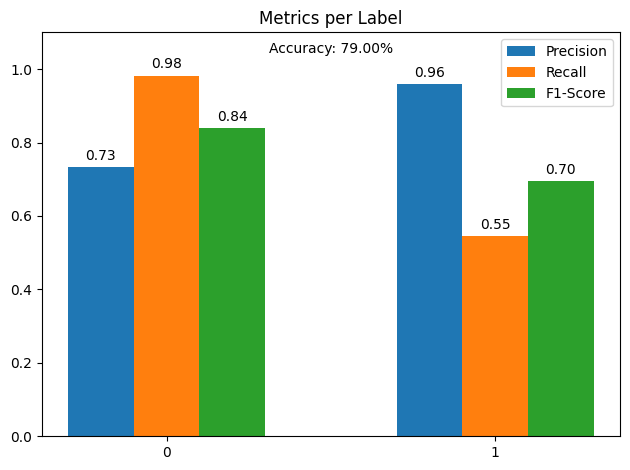

In [11]:
evaluate_model(model, X_test, y_test)